## Training a classifier

We are using CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

<img src="img/cifar10.png">

Generally we load image, text, audio or video data in numpy array using some standard python packages and convert them into `torch.*Tensor`

| Data Type | Useful packages |
|-----------------------------|
| Images | Pillow, OpenCV  | 
| Audio  | scipy, librosa  |
| Text | either raw Python or Cython based loading, or NLTK and SpaCy |

For image classification `torchvision` package provide data loader for common datasets such as Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz., `torchvision.datasets` and `torch.utils.data.DataLoader`

### Training steps
1. Load and normalizing the CIFAR10 training and test datasets using torchvision
1. Define a Convolution Neural Network
1. Define a loss function
1. Train the network on the training data
1. Test the network on the test data

### 1. Load and normalize CIFAR10

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1]

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


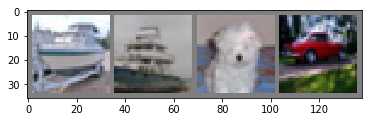

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))


In [7]:
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

 ship  ship   dog   car


### 2. Define a Convolution Neural Network

Copy the neural network from the Neural Networks section before and modify it to take 3-channel images (instead of 1-channel images as it was defined).


In [8]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 3. Define a Loss function and optimizer

Let’s use a Classification Cross-Entropy loss and SGD with momentum

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [10]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.191
[1,  4000] loss: 1.908
[1,  6000] loss: 1.712
[1,  8000] loss: 1.619
[1, 10000] loss: 1.538
[1, 12000] loss: 1.494
[2,  2000] loss: 1.428
[2,  4000] loss: 1.408
[2,  6000] loss: 1.388
[2,  8000] loss: 1.359
[2, 10000] loss: 1.347
[2, 12000] loss: 1.318
Finished Training


### 5. Test the network on the test data

GroundTruth:    cat  ship  ship plane


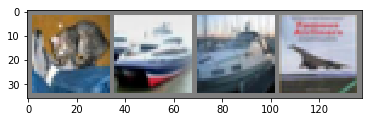

In [11]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [13]:
outputs = net(Variable(images))

_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   frog  ship   car  ship


In [14]:
# Let us look at how the network performs on the whole dataset.

correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


In [15]:
# what are the classes that performed well, and the classes that did not perform well:

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 64 %
Accuracy of   car : 85 %
Accuracy of  bird : 34 %
Accuracy of   cat : 19 %
Accuracy of  deer : 66 %
Accuracy of   dog : 32 %
Accuracy of  frog : 60 %
Accuracy of horse : 52 %
Accuracy of  ship : 66 %
Accuracy of truck : 40 %


### Training on GPU

Just like how you transfer a Tensor on to the GPU, you transfer the neural net onto the GPU. This will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

`net.cuda()`

Remember that you will have to send the inputs and targets at every step to the GPU too:

`inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())`

Why dont I notice MASSIVE speedup compared to CPU? Because your network is realllly small.

Exercise: Try increasing the width of your network (argument 2 of the first `nn.Conv2d`, and argument 1 of the second `nn.Conv2d` – they need to be the same number), see what kind of speedup you get.